<a href="https://colab.research.google.com/github/Sgwswag/Thesis/blob/main/LR_Tennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#General packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

#Avoid cluttering
import warnings
warnings.filterwarnings('ignore')

#Machine learning imports
from scipy.special import legendre
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#Statistical data visualization
import seaborn as sns

#This import is for the train_test_split function, which is used to split a dataset into training and testing sets.
from sklearn.model_selection import train_test_split

#In order to include various functions for evaluating the performance such as accuracy, precision, recall, F1 score, etc.
from sklearn import metrics

#Classification_report generates a text report showing the main classification metrics  (precision, recall, F1 score) for each class.
from sklearn.metrics import classification_report

#A variation of k-fold cross-validation that is useful when dealing with groups or clusters in the data to ensure that each group is present in only one of the folds.
from sklearn.model_selection import GroupKFold

#Performs a randomized search over a hyperparameter space for an estimator to find the best hyperparameters.
from sklearn.model_selection import RandomizedSearchCV

#Linear model for binary and multiclass classification (dependent variable is categorical).
from sklearn.linear_model import LogisticRegression

In [ ]:
#Setting up the environment for our data

#Check if it is running in Google Colab
try:
  import google.colab
  in_colab = True
except ImportError:
  in_colab = False

#Interact with the operating system, specifically working with file paths.
import os

#Ensure the current working directory is as expected
if in_colab:
  if os.getcwd() != '/content':
    os.chdir('../../')

  #Cloning the repository containing all the ATP Tennis data and features
  os.system('git clone https://github.com/JeffSackmann/tennis_atp')

#Setting the working directory
#os.chdir('/content/JeffSackmann/tennis_atp')
os.chdir('/content/tennis_atp')

In [ ]:
# Navigate to the tennis_atp directory
directory_path = '/content/tennis_atp/'
%cd {directory_path}

#String value 'atp_matches_', prefix used for naming match data files.
file_prefix = 'atp_matches_'
start_index, end_index = 1997, 2022
file_extension = '.csv'

#Define player and rankings files
players_file = 'atp_players.csv'
rankings_files = [
    'atp_rankings_20s.csv', 'atp_rankings_00s.csv', 'atp_rankings_10s.csv',
    'atp_rankings_70s.csv', 'atp_rankings_80s.csv', 'atp_rankings_90s.csv',
    'atp_rankings_current.csv'
]

/content


In [ ]:
#Designing a function to read the specific .csv files and return a list of DataFrames

def read_files(file_prefix, start_index, end_index, file_extension='.csv'):
  #Initializing an empty list to store the DataFrames
  dataframes_list = []

  #Iterating over a range of indices from st (start) to en (end)-(inclusive), defined above
  for index in range(start_index, end_index + 1):

    #Construct a file path p based on the prefix ft, index (converted to a string), and file extension
    file_path = f"{file_prefix}{index}{file_extension}"

    #Optional
    print(file_path)

    #Read the CSV file at the specified path into a DataFrame
    df = pd.read_csv(file_path)

    #Append the DataFrame to the list
    dataframes_list.append(df)

  return dataframes_list

Now, we want clean normalized data, but first we each atp_matches_ file contains all the tournaments and matches for a specific year, but that will result in about 100,000 different unique rows of data, good but in comparison to our markov chain we decide to go into the .csv file and select only the rows with matches that occured in in US Open.

In [ ]:
#Taking a list of data frames as the input
def concatenate_us_open_dataframes(dataframes):
  # Use the query method to filter each DataFrame based on the 'tourney_name' condition
  us_open_dataframes = [df.query("tourney_name.str.contains('US Open', case=False)", engine='python') for df in dataframes]

  # Concatenate the filtered DataFrames into a single DataFrame
  concatenated_df = pd.concat(us_open_dataframes, ignore_index=True)

  return concatenated_df

#Reading the .csv files
dataframes = read_files(file_prefix, start_index, end_index)

#The concatenated DataFrame containing data related to the 'US Open' tournaments
us_open_data = concatenate_us_open_dataframes(dataframes)

#Print the concatenated DataFrame
print(us_open_data)

atp_matches_1997.csv
atp_matches_1998.csv
atp_matches_1999.csv
atp_matches_2000.csv
atp_matches_2001.csv
atp_matches_2002.csv
atp_matches_2003.csv
atp_matches_2004.csv
atp_matches_2005.csv
atp_matches_2006.csv
atp_matches_2007.csv
atp_matches_2008.csv
atp_matches_2009.csv
atp_matches_2010.csv
atp_matches_2011.csv
atp_matches_2012.csv
atp_matches_2013.csv
atp_matches_2014.csv
atp_matches_2015.csv
atp_matches_2016.csv
atp_matches_2017.csv
atp_matches_2018.csv
atp_matches_2019.csv
atp_matches_2020.csv
atp_matches_2021.csv
atp_matches_2022.csv
     tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0      1997-560      US Open    Hard        128             G      19970825   
1      1997-560      US Open    Hard        128             G      19970825   
2      1997-560      US Open    Hard        128             G      19970825   
3      1997-560      US Open    Hard        128             G      19970825   
4      1997-560      US Open    Hard        128            

In [ ]:
#Information about the columns.
us_open_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          3302 non-null   object 
 1   tourney_name        3302 non-null   object 
 2   surface             3302 non-null   object 
 3   draw_size           3302 non-null   int64  
 4   tourney_level       3302 non-null   object 
 5   tourney_date        3302 non-null   int64  
 6   match_num           3302 non-null   int64  
 7   winner_id           3302 non-null   int64  
 8   winner_seed         1732 non-null   float64
 9   winner_entry        300 non-null    object 
 10  winner_name         3302 non-null   object 
 11  winner_hand         3302 non-null   object 
 12  winner_ht           3300 non-null   float64
 13  winner_ioc          3302 non-null   object 
 14  winner_age          3302 non-null   float64
 15  loser_id            3302 non-null   int64  
 16  loser_

Now we have all the data with all the features from the US open, but now we need a way that our model will use it, i.e., as a classification problem, we want 0 and 1, 0 indicates a winner, 1 indicates a loser: the way the columns are structured, each row is a match, with data of the match, including who won and who lost and their stats; thanks to (https://github.com/chief-r0cka/MLT/blob/master/Eda-data-prep-modeling-predictions-then-betting.ipynb and
https://www.kaggle.com/code/ahlemj/predict-atp-tennis and https://github.com/andmon97/ATPTennisMatchPredictions/tree/main for preprocessing and setting y); they create a new column y and give it values 0 and 1, 0 if the winner is in the winner column and 1 if the loser is in the winner column. Having an equal number of 0 and 1 is better for the model, so it arbitraily gives the first half of the set 0 in the y column and the second half 1; then it swaps the columns of the players with the value 1 so the loser data is in the winner column, then just shuffling the rows for better representation

In [ ]:
#Determine the length as half of the number of rows in the DataFrame
half_length = int(len(us_open_data) / 2)

#Create a binary outcome variable 'y' representing match outcomes
y = np.concatenate([np.zeros(half_length), np.ones(half_length)])

#Create a new column 'y' in the us_open_data DataFrame and set its values based on the 'y' array
us_open_data['y'] = pd.Series(y, index=us_open_data.index)

In [ ]:
#Effectively extracts the first half and second half of the DataFrame(slicing up to length which is divided by 2)
matches1 = us_open_data[:int(half_length)]
matches2 = us_open_data[int(half_length):]

#Writing the extracted data to a .csv file with first and second half but not into the csv file
matches1.to_csv('all_matches_firsthalf.csv', encoding='utf-8', index=False)
matches2.to_csv('all_matches_secondhalf.csv', encoding='utf-8', index=False)

#Displaying the first few rows
#all_matches1.head()
#all_matches2.head()

In [ ]:
#Now that all the 0 and 1 are set, need to swap the rows, just for the first half

#Get the column names as a list
column_names = list(matches1)

#Define the ranges of columns to swap
first_range = range(7, 17)
second_range = range(17, 27)

#Swap columns 17 to 26 with columns 7 to 16
for i, j in zip(second_range, first_range):
    column_names[i], column_names[j] = column_names[j], column_names[i]

#Reorder the columns of the DataFrame based on the swaps made
matches1 = matches1[column_names]

In [ ]:
#From the github, renaming the rows
#Renaming columns in the DataFrames to more generic names: "Loser" and "Winner" with "Player1" and "Player2" according to the outcome of the match represented by the value of y; 1 for when player1 is the winner and 0 otherwise
matches1.rename(columns={'loser_id':'Player1_id', 'loser_seed':'Player1_seed', 'loser_entry':'Player1_entry', 'loser_name':'Player1_name', 'loser_hand':'Player1_hand', 'loser_ht':'Player1_ht', 'loser_ioc':'Player1_ioc', 'loser_age':'Player1_age', 'loser_rank':'Player1_rank', 'loser_rank_points':'Player1_rank_points','winner_id':'Player2_id', 'winner_seed':'Player2_seed', 'winner_entry':'Player2_entry', 'winner_name':'Player2_name', 'winner_hand':'Player2_hand', 'winner_ht':'Player2_ht', 'winner_ioc':'Player2_ioc', 'winner_age':'Player2_age', 'winner_rank':'Player2_rank', 'winner_rank_points':'Player2_rank_points'},inplace=True)
matches2.rename(columns={'loser_id':'Player2_id', 'loser_seed':'Player2_seed', 'loser_entry':'Player2_entry', 'loser_name':'Player2_name', 'loser_hand':'Player2_hand', 'loser_ht':'Player2_ht', 'loser_ioc':'Player2_ioc', 'loser_age':'Player2_age', 'loser_rank':'Player2_rank', 'loser_rank_points':'Player2_rank_points','winner_id':'Player1_id', 'winner_seed':'Player1_seed', 'winner_entry':'Player1_entry', 'winner_name':'Player1_name', 'winner_hand':'Player1_hand', 'winner_ht':'Player1_ht', 'winner_ioc':'Player1_ioc', 'winner_age':'Player1_age', 'winner_rank':'Player1_rank', 'winner_rank_points':'Player1_rank_points'},inplace=True)

In [ ]:
#Combining the data into a single DataFrame
combine = [matches1,matches2]
all_us_open_matches= pd.concat(combine)

In [ ]:
from sklearn.utils import shuffle

# Randomly shuffle the rows of the DataFrame
all_us_open_matches = shuffle(all_us_open_matches)
all_us_open_matches.to_csv('all_us_open_matches.csv', encoding='utf-8', index=False)

#Results of the shuffling
all_us_open_matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,Player1_entry,Player1_name,Player1_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,Player2_rank,Player2_rank_points,Player1_rank,Player1_rank_points,y
2191,2014-560,US Open,Hard,128,G,20140825,33,NaN,Tomas Berdych,R,...,28.0,23.0,14.0,13.0,19.0,41.0,1050.0,7.0,4060.0,1.0
1036,2005-560,US Open,Hard,128,G,20050829,21,NaN,Agustin Calleri,R,...,54.0,38.0,23.0,14.0,25.0,15.0,1420.0,67.0,547.0,0.0
921,2004-560,US Open,Hard,128,G,20040830,33,NaN,Dennis Van Scheppingen,R,...,38.0,17.0,15.0,8.0,15.0,9.0,1990.0,73.0,552.0,0.0
2862,2019-560,US Open,Hard,128,G,20190826,168,Q,Dominik Koepfer,L,...,50.0,15.0,16.0,3.0,6.0,42.0,1076.0,118.0,474.0,1.0
2633,2017-560,US Open,Hard,128,G,20170828,193,Q,Mikhail Kukushkin,R,...,41.0,27.0,16.0,7.0,12.0,99.0,549.0,103.0,538.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1998-560,US Open,Hard,128,G,19980831,65,WC,Paul Goldstein,R,...,71.0,12.0,19.0,2.0,5.0,1.0,3678.0,256.0,157.0,0.0
1349,2007-560,US Open,Hard,128,G,20070827,80,NaN,Fabrice Santoro,R,...,61.0,23.0,24.0,13.0,22.0,6.0,2390.0,44.0,724.0,0.0
627,2001-560,US Open,Hard,128,G,20010827,120,NaN,Roger Federer,R,...,17.0,15.0,13.0,1.0,6.0,2.0,3870.0,13.0,1815.0,0.0
698,2002-560,US Open,Hard,128,G,20020826,64,NaN,Nicolas Kiefer,R,...,70.0,38.0,26.0,14.0,21.0,2.0,3130.0,64.0,615.0,0.0


Now we have all of our data, appropriately named, organized, but normalizing the data will gives us a more accurate model relative to each other.

In [ ]:
#Define player-related columns
player_columns = ['Player1_id', 'Player1_name', 'Player2_id', 'Player2_name']

#Define features to drop
features_to_drop = ['tourney_id', 'tourney_date', 'score', 'match_num', 'tourney_name', 'surface', 'draw_size', 'tourney_level','best_of']

#Define categorical columns
categorical_columns = ['Player1_entry', 'Player1_hand', 'Player1_ioc',
                        'Player2_entry', 'Player2_hand', 'Player2_ioc',
                        'round']

#Define numeric columns
numeric_columns = ['Player1_seed', 'Player1_ht', 'Player1_age', 'Player1_rank', 'Player1_rank_points',
                   'Player2_seed', 'Player2_ht', 'Player2_age', 'Player2_rank', 'Player2_rank_points',
                   'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
                   'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
                   'l_bpSaved', 'l_bpFaced']

#Drop specified features from the DataFrame
df = pd.read_csv('all_us_open_matches.csv')
df = df.drop(features_to_drop, axis=1)

In [ ]:
#Handling missing values
#For each column specified in cat_cols, replace missing values (np.NaN) with the mode of the respective column, and for the numeric it replaces with the mean
print("Categorical Features")
for cat_column in categorical_columns:
    #Replace missing values with the mode of the respective column
    df[cat_column].fillna(df[cat_column].mode()[0], inplace=True)
    print(cat_column)

#Handling missing values in numeric columns
print("Numerical Features\n")
for num_column in numeric_columns:
    #print(num_column)
    #Replace missing values with the mean of the respective column
    df[num_column].fillna(df[num_column].mean(), inplace=True)
    print(num_column)

Categorical Features
Player1_entry
Player1_hand
Player1_ioc
Player2_entry
Player2_hand
Player2_ioc
round
Numerical Features

Player1_seed
Player1_ht
Player1_age
Player1_rank
Player1_rank_points
Player2_seed
Player2_ht
Player2_age
Player2_rank
Player2_rank_points
minutes
w_ace
w_df
w_svpt
w_1stIn
w_1stWon
w_2ndWon
w_SvGms
w_bpSaved
w_bpFaced
l_ace
l_df
l_svpt
l_1stIn
l_1stWon
l_2ndWon
l_SvGms
l_bpSaved
l_bpFaced


In [ ]:
def convert_categorical_to_numeric(dataframe):
    #Use get_dummies to perform one-hot encoding on categorical columns
    #One-hot encoding converts categorical variables into a binary matrix (0s and 1s)
    dataframe_encoded = pd.get_dummies(dataframe, columns=categorical_columns)
    return dataframe_encoded

df = convert_categorical_to_numeric(df)

In [ ]:
def normalize_numeric_features(dataframe, numeric_columns):
    normalized_df = dataframe.copy()

    # Normalize each numeric feature in the given list
    for feature_name in numeric_columns:
        max_value = dataframe[feature_name].max()
        min_value = dataframe[feature_name].min()

        # Normalize the values of the feature using the formula (value - min_value) / (max_value - min_value)
        normalized_df[feature_name] = (dataframe[feature_name] - min_value) / (max_value - min_value)

    return normalized_df

# Normalize numeric features in the DataFrame df using the specified numeric columns
df = normalize_numeric_features(df, numeric_columns)
df.head()

,Player1_name,Player1_ht,Player1_age,minutes,Player2_id,Player2_seed,Player2_name,Player2_ht,Player2_age,Player1_id,...,Player2_ioc_USA,Player2_ioc_UZB,Player2_ioc_ZIM,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_SF
0,Tomas Berdych,0.651163,0.584475,0.432692,103720,0.391667,Lleyton Hewitt,0.279070,0.647287,104607,...,0,0,0,0,0,1,0,0,0,0
1,Agustin Calleri,0.348837,0.584475,0.794872,103970,0.500000,David Ferrer,0.162791,0.259690,102860,...,0,0,0,0,0,1,0,0,0,0
2,Dennis Van Scheppingen,0.395349,0.593607,0.432692,103900,0.218750,David Nalbandian,0.279070,0.228682,102615,...,0,0,0,0,0,1,0,0,0,0
3,Dominik Koepfer,0.279070,0.420091,0.461538,124187,0.391667,Reilly Opelka,1.000000,0.201550,136440,...,1,0,0,0,0,0,0,0,1,0
4,Mikhail Kukushkin,0.348837,0.616438,0.464744,105539,0.391667,Evgeny Donskoy,0.395349,0.410853,105062,...,0,0,0,0,0,0,0,0,1,0


Now that the data is all set, normalized, etc, we can work on the model; first some general configurations.

In [ ]:
#Create a new DataFrame Y containing only the target variable 'y' from the original DataFrame
target_variable = 'y'
Y = pd.DataFrame(df[target_variable])

#Remove the target variable 'y' column from the original DataFrame
features_df = df.drop([target_variable], axis=1)

#Assign the DataFrame without the target variable to X, representing the features for training the ML model
X = features_df

#Use train_test_split to split features and target variable into training and testing sets
#X_train and y_train represent the features and labels for the training set
#X_test and y_test represent the features and labels for the testing set (to evaluate performance)
#The test_size=0.33 indicates that 33% of the data will be used for testing, and the remaining 67% for training
random_seed = 1107
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=random_seed)

In [ ]:
#List of columns to drop from X_train
columns_to_drop = ['Player1_id', 'Player1_name', 'Player2_id', 'Player2_name']

#Drop the specified columns from X_train
X_train = X_train.drop(columns=columns_to_drop)

In [ ]:
#Initialize an empty list to store pairs of player names
test_names = []

#Loop through each row in X_test to extract player names ('Player1_name' and 'Player2_name')
for _, row in X_test.iterrows():
    #Create a list to store a pair of player names for the current row
    player_pair = [row['Player1_name'], row['Player2_name']]

    #Append the list containing player names to the main list test_names
    test_names.append(player_pair)

In [ ]:
#List of columns to drop from X_test
columns_to_drop_test = ['Player1_id', 'Player1_name', 'Player2_id', 'Player2_name']

#Drop the specified columns from X_test
X_test = X_test.drop(columns=columns_to_drop_test)

In [ ]:
#Defining the model
logistic_regression_model = LogisticRegression()

#Define the search space for hyperparameters through param_grid
param_grid = {
    'C': np.logspace(0, 4, num=10),  #Regularization parameter values sampled from a logarithmic scale between 1 and 10000
    'penalty': ['l1', 'l2'],         #Regularization penalty options, either 'l1' or 'l2'
    'solver': ['liblinear', 'sag']   #ptions for the algorithm to use in the optimization problem, either 'liblinear' or 'sag'
}

#Using RandomizedSearchCV to search over the hyperparameter space
search = RandomizedSearchCV(logistic_regression_model, param_grid, n_iter=5, cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

#Fitting the logistic regression model to the training data, searching over the hyperparameter space
result = search.fit(X_train, y_train)

#Print the results
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.834974114385879
Best Hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'C': 1291.5496650148827}


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Make predictions on the test set using the best model from the hyperparameter search
y_pred = result.predict(X_test)

#Here is how we evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

#Display model evaluation metrics
print('\nModel Evaluation:')
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Model Evaluation:
Accuracy: 0.8532
Confusion Matrix:
[[484  77]
 [ 83 446]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       561
         1.0       0.85      0.84      0.85       529

    accuracy                           0.85      1090
   macro avg       0.85      0.85      0.85      1090
weighted avg       0.85      0.85      0.85      1090



In [ ]:
# Extract the best model from the hyperparameter search
best_model = result.best_estimator_

# Get coefficients and feature names
coefficients = best_model.coef_
feature_names = X_train.columns

# Filter out unwanted features and prepare lists for two-column display
filtered_features = [(f, c) for f, c in zip(feature_names, coefficients[0])
                     if not f.startswith('Player1_ioc') and not f.startswith('Player2_ioc')]

# Calculate midpoint to split the list for two columns
mid_index = len(filtered_features) // 2

# Pair each feature with its corresponding pair in the second column, filling with blanks if uneven number
paired_features = list(zip(filtered_features[:mid_index], filtered_features[mid_index:] + [("", "")] * (mid_index - len(filtered_features[mid_index:]))))

# Display feature importance in two columns
print('\nFeature Importance:')
for (f1, c1), (f2, c2) in paired_features:
    print(f'{f1:20s}: {c1:<10.4f}    {f2:20s}: {c2:10.4f}')



Feature Importance:
Player1_ht          : 1.7394        l_bpSaved           :     3.1693
Player1_age         : 2.9236        l_bpFaced           :    -2.4835
minutes             : 15.0542       Player2_rank        :    14.7081
Player2_seed        : 2.1623        Player2_rank_points :     0.8328
Player2_ht          : 3.0020        Player1_rank        :    -0.5019
Player2_age         : 5.6505        Player1_rank_points :    20.6437
Player1_seed        : 3.1681        Player1_entry_LL    :    -2.9276
w_ace               : 0.5691        Player1_entry_Q     :    -0.6203
w_df                : -0.4922       Player1_entry_WC    :    -0.4112
w_svpt              : -5.2401       Player1_hand_L      :    -1.8834
w_1stIn             : 4.5827        Player1_hand_R      :    -2.0757
w_1stWon            : -8.8043       Player2_entry_LL    :    -1.2237
w_2ndWon            : -2.3280       Player2_entry_Q     :    -1.4103
w_SvGms             : 5.0373        Player2_entry_WC    :    -1.3251
w_bpSaved    

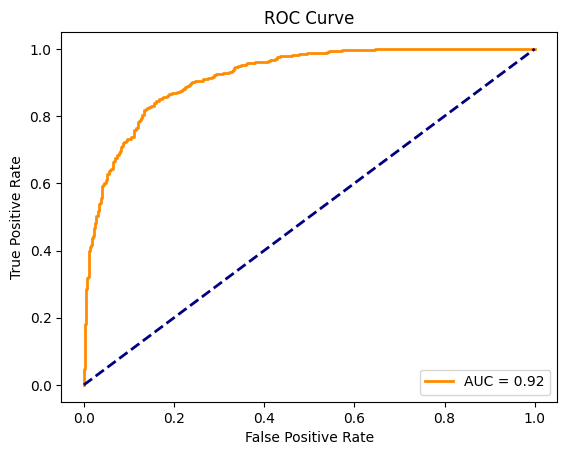

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])

#Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

#Plot ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

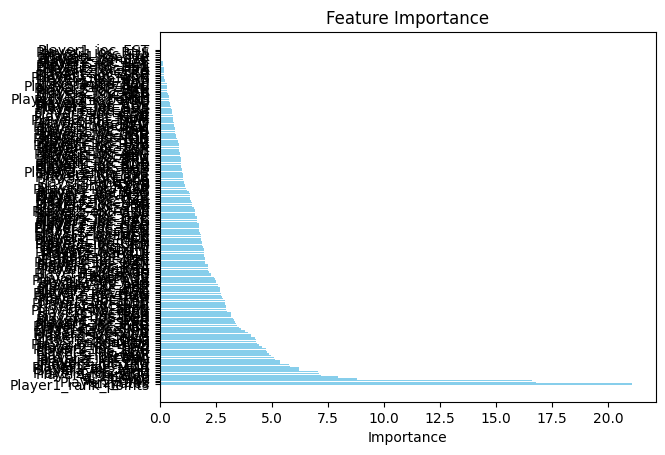

In [ ]:
#Assuming 'feature_names' and 'coefficients' are obtained from the trained model
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients[0])})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

#Plot Feature Importance
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()